## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [38]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [40]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [41]:
train_dataset, val_dataset = torch.utils.data.random_split(fmnist_dataset_train, [50000, 10000])
print(len(fmnist_dataset_train))
print(len(train_dataset))
print(len(val_dataset))

60000
50000
10000


In [42]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=128,
                                           shuffle = False,
                                           num_workers = 0)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=0)

In [43]:
len(fmnist_dataset_test)

10000

In [44]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [45]:


for x, y in train_loader:
    print(x.shape)
    break

torch.Size([128, 1, 28, 28])


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [46]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here

            nn.Linear(input_shape, 196),
            nn.Dropout(0.2),
            nn.BatchNorm1d(196, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(196, 49),
            nn.Dropout(0.2),
            nn.BatchNorm1d(49, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(49, num_classes),
            nn.BatchNorm1d(num_classes, eps = 1e-3, momentum = 0.1),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [47]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 196]         153,860
           Dropout-3                  [-1, 196]               0
       BatchNorm1d-4                  [-1, 196]             392
         LeakyReLU-5                  [-1, 196]               0
            Linear-6                   [-1, 49]           9,653
           Dropout-7                   [-1, 49]               0
       BatchNorm1d-8                   [-1, 49]              98
         LeakyReLU-9                   [-1, 49]               0
           Linear-10                   [-1, 10]             500
      BatchNorm1d-11                   [-1, 10]              20
       LogSoftmax-12                   [-1, 10]               0
Total params: 164,523
Trainable params: 164,523
Non-trainable params: 0
-------------------------------

Your experiments come here:

In [48]:
# Your experiments, training and validation loops here
import time

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device, decr_coeff = 1, decr_ep_n = 10):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    counter = 0
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_train_accuracy = []
        ep_val_accuracy = []
        start_time = time.time()
        counter += 1
        if counter == decr_ep_n:
            counter = 0
            for g in opt.param_groups:
                g['lr'] = g['lr'] / decr_coeff

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())
            ep_train_accuracy.append(torch_accuracy_score(y_batch, model(X_batch)))

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
                out = model(X_batch)
                loss = loss_fn(out, y_batch)

                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))

        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t training loss: {train_loss[-1]:.6f}")
        print(f"\t training accuracy: {train_accuracy[-1]:.6f}")
        print(f"\t validation loss: {val_loss[-1]:.6f}")
        print(f"\t validation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, train_accuracy, val_loss, val_accuracy

def torch_accuracy_score(y_true, predictions):
    y_pred = predictions.max(dim=1)[1]
    return np.mean(np.array(y_true.cpu() == y_pred.cpu()))

def plot_training(tr_loss, tr_acc, val_loss, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].set_title('Accuracy')
    axes[0].plot(tr_acc, label='Training accuracy')
    axes[0].plot(val_acc, label='Validation accuracy')
    axes[0].set_xlabel('n epoch')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_title('Loss')
    axes[1].plot(tr_loss, label='Training loss')
    axes[1].plot(val_loss, label='Validation loss')
    axes[1].set_xlabel('n epoch')
    axes[1].grid(True)
    axes[1].legend()

    plt.show()

def model_test_score(model, test_loader):
    test_accuracy = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            test_accuracy.append(torch_accuracy_score(y_batch.flatten(), predictions))

    return np.mean(test_accuracy)

In [49]:
n_epochs = 30
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.99) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, val_loader,
                                                 loss_fn=loss_func, opt=opt, n_epochs=n_epochs,
                                                 decr_coeff=4, decr_ep_n=10)

Epoch 1 of 30 took 7.215s
	 training loss: 0.834389
	 training accuracy: 0.746823
	 validation loss: 0.483158
	 validation accuracy: 0.827
Epoch 2 of 30 took 7.385s
	 training loss: 0.502832
	 training accuracy: 0.831506
	 validation loss: 0.411106
	 validation accuracy: 0.854
Epoch 3 of 30 took 6.317s
	 training loss: 0.445460
	 training accuracy: 0.846316
	 validation loss: 0.378930
	 validation accuracy: 0.863
Epoch 4 of 30 took 6.326s
	 training loss: 0.415981
	 training accuracy: 0.856837
	 validation loss: 0.364751
	 validation accuracy: 0.868
Epoch 5 of 30 took 7.501s
	 training loss: 0.395288
	 training accuracy: 0.861845
	 validation loss: 0.350272
	 validation accuracy: 0.873
Epoch 6 of 30 took 6.793s
	 training loss: 0.378080
	 training accuracy: 0.866496
	 validation loss: 0.346390
	 validation accuracy: 0.872
Epoch 7 of 30 took 7.297s
	 training loss: 0.372197
	 training accuracy: 0.868530
	 validation loss: 0.338351
	 validation accuracy: 0.877
Epoch 8 of 30 took 6.667s
	

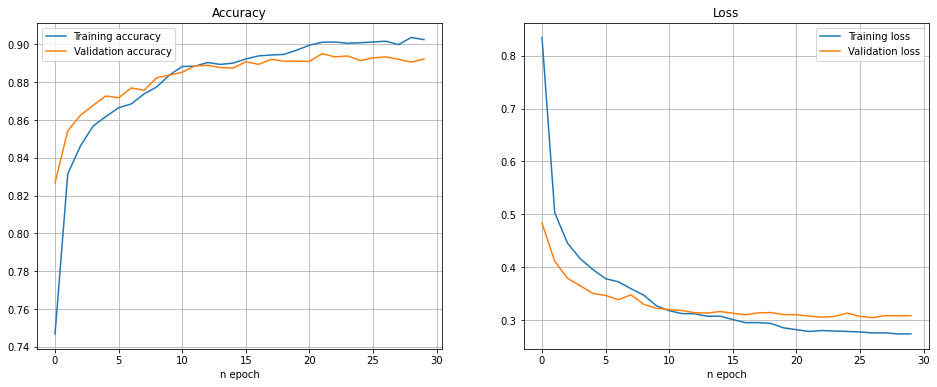

In [50]:
plot_training(tr_loss, tr_acc, val_loss, val_acc)

In [51]:
model.eval()
test_acc = model_test_score(model, test_loader)
print('test accuracy:\t{:.3f}'.format(test_acc))

test accuracy:	0.884


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [52]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.LeakyReLU(),
            nn.Linear(input_shape, input_shape),
            nn.LeakyReLU(),
            nn.Linear(input_shape, 392),
            # nn behavior was pretty inadequate without this BatchNorm
            nn.BatchNorm1d(392, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(392, 196),
            nn.LeakyReLU(),
            nn.Linear(196, 98),
            # and this BatchNorm
            nn.BatchNorm1d(98, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(98, 49),
            nn.LeakyReLU(),
            nn.Linear(49, num_classes),
            nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [53]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
         LeakyReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 784]         615,440
         LeakyReLU-5                  [-1, 784]               0
            Linear-6                  [-1, 392]         307,720
       BatchNorm1d-7                  [-1, 392]             784
         LeakyReLU-8                  [-1, 392]               0
            Linear-9                  [-1, 196]          77,028
        LeakyReLU-10                  [-1, 196]               0
           Linear-11                   [-1, 98]          19,306
      BatchNorm1d-12                   [-1, 98]             196
        LeakyReLU-13                   [-1, 98]               0
           Linear-14                   

In [54]:
n_epochs = 100
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.99) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

In [55]:
# Your experiments, come here

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, val_loader,
                                                 loss_fn=loss_func, opt=opt, n_epochs=n_epochs, decr_coeff=2)

Epoch 1 of 100 took 7.114s
	 training loss: 0.782481
	 training accuracy: 0.765493
	 validation loss: 0.428063
	 validation accuracy: 0.847
Epoch 2 of 100 took 6.995s
	 training loss: 0.382077
	 training accuracy: 0.861861
	 validation loss: 0.364592
	 validation accuracy: 0.867
Epoch 3 of 100 took 7.014s
	 training loss: 0.331549
	 training accuracy: 0.877470
	 validation loss: 0.345990
	 validation accuracy: 0.870
Epoch 4 of 100 took 7.000s
	 training loss: 0.314203
	 training accuracy: 0.884023
	 validation loss: 0.340258
	 validation accuracy: 0.876
Epoch 5 of 100 took 7.133s
	 training loss: 0.305557
	 training accuracy: 0.884479
	 validation loss: 0.355721
	 validation accuracy: 0.874
Epoch 6 of 100 took 7.001s
	 training loss: 0.285163
	 training accuracy: 0.895157
	 validation loss: 0.323875
	 validation accuracy: 0.881
Epoch 7 of 100 took 6.994s
	 training loss: 0.270620
	 training accuracy: 0.899684
	 validation loss: 0.309366
	 validation accuracy: 0.887
Epoch 8 of 100 took 

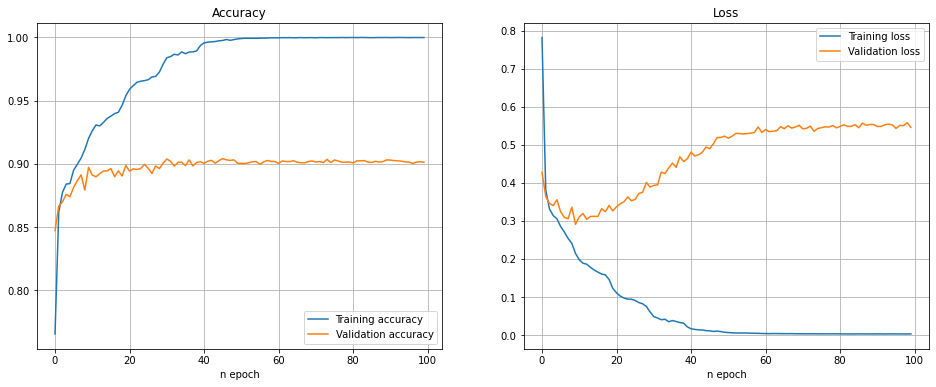

In [56]:
plot_training(tr_loss, tr_acc, val_loss, val_acc)

In [57]:
model.eval()
test_acc = model_test_score(model, test_loader)
print('test accuracy:\t{:.3f}'.format(test_acc))

test accuracy:	0.898


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [58]:
# the best solution is to reduce model complexity, but I don' have such option, so...

class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.Dropout(0.3),
            nn.BatchNorm1d(input_shape, eps = 1e-3, momentum = 0.75),
            nn.LeakyReLU(),
            nn.Linear(input_shape, input_shape),
            nn.Dropout(0.3),
            nn.BatchNorm1d(input_shape, eps = 1e-3, momentum = 0.75),
            nn.LeakyReLU(),
            nn.Linear(input_shape, 392),
            nn.Dropout(0.2),
            nn.BatchNorm1d(392, eps = 1e-3, momentum = 0.75),
            nn.LeakyReLU(),
            nn.Linear(392, 196),
            nn.BatchNorm1d(196, eps = 1e-3, momentum = 0.75),
            nn.LeakyReLU(),
            nn.Linear(196, 98),
            nn.BatchNorm1d(98, eps = 1e-3, momentum = 0.75),
            nn.LeakyReLU(),
            nn.Linear(98, 49),
            nn.BatchNorm1d(49, eps = 1e-3, momentum = 0.75),
            nn.LeakyReLU(),
            nn.Linear(49, num_classes),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [59]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
           Dropout-3                  [-1, 784]               0
       BatchNorm1d-4                  [-1, 784]           1,568
         LeakyReLU-5                  [-1, 784]               0
            Linear-6                  [-1, 784]         615,440
           Dropout-7                  [-1, 784]               0
       BatchNorm1d-8                  [-1, 784]           1,568
         LeakyReLU-9                  [-1, 784]               0
           Linear-10                  [-1, 392]         307,720
          Dropout-11                  [-1, 392]               0
      BatchNorm1d-12                  [-1, 392]             784
        LeakyReLU-13                  [-1, 392]               0
           Linear-14                  [

In [60]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.99) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE
n_epochs = 100

# Your experiments, come here

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, val_loader,
                                                 loss_fn=loss_func, opt=opt, n_epochs=n_epochs,
                                                 decr_coeff=2)

Epoch 1 of 100 took 7.884s
	 training loss: 0.855048
	 training accuracy: 0.711545
	 validation loss: 0.557152
	 validation accuracy: 0.794
Epoch 2 of 100 took 7.944s
	 training loss: 0.452989
	 training accuracy: 0.834395
	 validation loss: 0.400967
	 validation accuracy: 0.854
Epoch 3 of 100 took 7.828s
	 training loss: 0.395070
	 training accuracy: 0.853824
	 validation loss: 0.385185
	 validation accuracy: 0.861
Epoch 4 of 100 took 7.856s
	 training loss: 0.371045
	 training accuracy: 0.861733
	 validation loss: 0.383081
	 validation accuracy: 0.861
Epoch 5 of 100 took 8.043s
	 training loss: 0.352514
	 training accuracy: 0.869737
	 validation loss: 0.359830
	 validation accuracy: 0.869
Epoch 6 of 100 took 7.899s
	 training loss: 0.337979
	 training accuracy: 0.875024
	 validation loss: 0.357571
	 validation accuracy: 0.871
Epoch 7 of 100 took 8.210s
	 training loss: 0.326149
	 training accuracy: 0.879312
	 validation loss: 0.348331
	 validation accuracy: 0.875
Epoch 8 of 100 took 

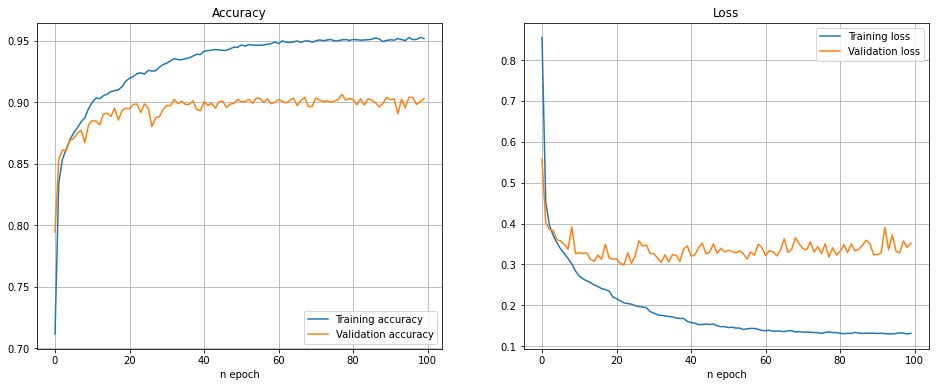

In [61]:
plot_training(tr_loss, tr_acc, val_loss, val_acc)

In [62]:
model.eval()
test_acc = model_test_score(model, test_loader)
print('test accuracy:\t{:.3f}'.format(test_acc))

test accuracy:	0.894


### Conclusions:
_Write down small report with your conclusions and your ideas._

* На обучении первой модели learningRate уменьшался в 4 раза на 10 эпох.
* На обучении второй и третьей моделей learningRate уменьшался в
2 раза на 10 эпох.

От первой сети ко второй значительно увеличилась сложность модели
 (число параметров увеличилось в 10 раз: с 164 523 до 1 641 265).
 Большое число параметров — залог хорошей переобучаемости :)

Уже на первой модели можно было наблюдать эффект переобучения, поэтому там
и добавлена пара Dropout-ов. На второй же модели их нет.
К тому же обучение второй модели происходит значительно дольше,
что тоже позволяет её переобучить.

На выходе второй модели мы можем видеть, что она вполне себе неплохо
запомнила обучающую выборку: точность на ней достигает 0.9999.
При этом loss функция на валидационной выборке растёт начиная примерно
с 10-ой эпохи. Тем не менее, такая переобученность не помешала второй модели
набрать достаточно хороший score: 0.897

В третью модель я понапихал BatchNormalization-ов и Dropout-ов,
что помогло избавиться от переобучения: loss-функция не растёт,
обучающая выборка не заучивается наизусть (training accuracy: 0.951646).
Однако score модели без переобучения оказался таким же, как и у
переобученной: 0.897.

Score первой модели, к слову, составляет 0.889.
